In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from category_encoders import OneHotEncoder
from tqdm import tqdm

#K-prototypesクラスタリング
from kmodes.kprototypes import KPrototypes

#可視化様にUmapで次元削減
import umap.umap_ as umap
from scipy.sparse.csgraph import connected_components


中古バイク同士のグループ化していく。    
train_dataとtest_data両方を使う  
今回はカテゴリー変数を含むdataであるため通常のKmeansや階層型クラスタリングを使えないため、K-prototypesクラスタリングを実装する。  
(特にバイクの類似度において色、メーカー、タイプは重要視されるという考え折り込みたいと考えた。)  
Kprototypesは数値データはユークリッド距離で、カテゴリー変数は単純マッチング距離(相違度)で距離を測る。    
model_year,guarantee_periodに関しては特徴量から除いた。(離散的なため正規分布に従わず、カテゴリー変数としてもグループ数が多く扱い辛いため)

In [176]:
#データの読み込み
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)

In [177]:
model_data

,model_number,brand,name,type,displacement
0,0E71,BMW,M1000RR,スポーツ/ツアラー,1000.0
1,0J51,BMW,R1250GS,オフロード/モタード,1250.0
2,0K11,BMW,F900R ABS,ネイキッド,900.0
3,0L11,BMW,R18 Classic,アメリカン/クルーザー,1800.0
4,1290 SUPER DUKE GT,KTM,1290 SUPER DUKE GT,ネイキッド,1290.0
...,...,...,...,...,...
849,ZXT00N,KAWASAKI,Ninja,スポーツ/ツアラー,1000.0
850,ZXT00S,KAWASAKI,Ninja ZX10R ABS KRT Edition,スポーツ/ツアラー,1000.0
851,ZXT40A,KAWASAKI,ZZR1400,スポーツ/ツアラー,1400.0
852,ZXT40E,KAWASAKI,Ninja ZX14R ABS,スポーツ/ツアラー,1400.0


In [178]:
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーをdataから外す。
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
all_data = info_data.merge(model_data,on='model_number',how='left')
all_data.dropna(inplace=True)

In [179]:
all_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement
0,2100006155617,118000,JBH-AF67,2012.0,黒,2742.0,0.25,51,HONDA,ﾄｩﾃﾞｲ,スクーター/ビッグスクーター,50.0
1,2100004366077,1378000,EBL-NC42,2019.0,黒,776.0,5.00,2,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0
2,2100005457217,348000,JBK-ER250C,2013.0,白,11979.0,1.00,58,KAWASAKI,Z250,ネイキッド,250.0
3,2100005410007,578000,EBL-RH07J,2020.0,黒,4500.0,5.00,37,YAMAHA,MT03,ネイキッド,320.0
4,2100005346689,568000,JUE4,2021.0,黒,5688.0,5.00,81,Husqvarna,SVARTPILEN 250,ネイキッド,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6102,2100006097726,1018000,8BL-RM39J,2022.0,青,2964.0,7.00,67,YAMAHA,YZFR7,スポーツ/ツアラー,700.0
6103,2100006214697,798000,BC-SK44A,2008.0,黒,11745.0,0.25,3,SUZUKI,DRZ400SM,オフロード/モタード,400.0
6104,2100006202625,1198000,EBL-SC59,2013.0,オレンジ,23013.0,1.00,74,HONDA,CBR1000RR,スポーツ/ツアラー,1000.0
6105,2100006271508,466000,JBK-RG10J,2019.0,赤,5895.0,5.00,54,YAMAHA,YZFR25,スポーツ/ツアラー,250.0


In [182]:
#クラスタリングする特徴量は入力データと同じにする必要がある。
#あとでダミー変数を取るときに後ろにカテゴリー変数を固めておいた方が良い
data = all_data[['cost','mileage','displacement','color','brand','type']]

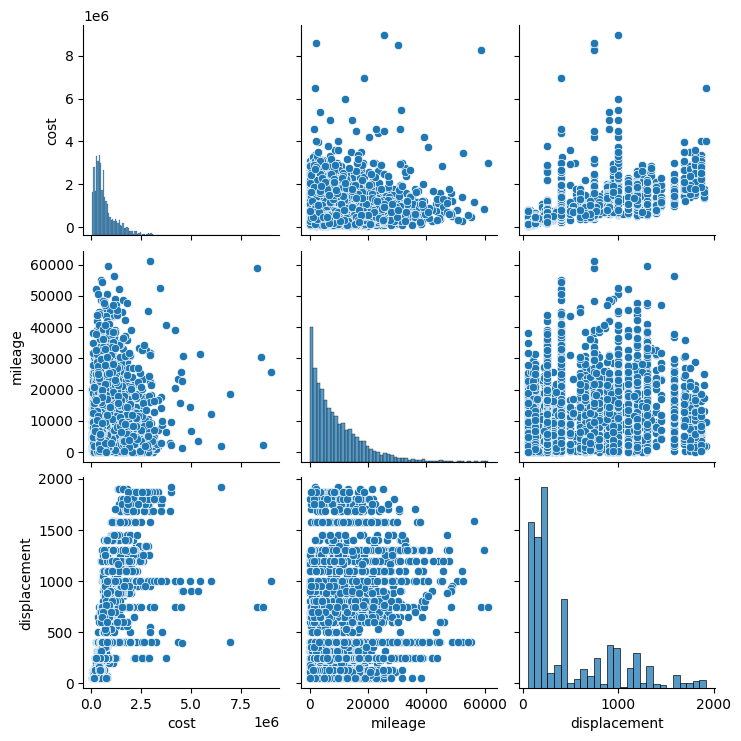

In [183]:
sns.pairplot(data)
plt.show()

# データの前処理

kmeansも階層型も正規化をして指標を合わせる必要がある。  
数値データ(cost,mileage,displacement)は標準化    
カテゴリー変数はエンコーディング不要。(ただしUMAPでの可視化を行うためダミーエンコーディングデータも用意する。)

In [184]:
data_scaler = data.copy()

In [185]:
numeric_feature = ['cost','mileage','displacement']
# d_numeric_feature = ['model_year','guarantee_period']
# min_max = MinMaxScaler()
# min_max.fit(data[d_numeric_feature])


In [186]:
# data_scaler[d_numeric_feature] = min_max.transform(data[d_numeric_feature])

In [187]:
for c in numeric_feature :
    pt = PowerTransformer(method='yeo-johnson')
    data_scaler[c] = pt.fit_transform(data_scaler[[c]])

In [188]:
data_scaler

,cost,mileage,displacement,color,brand,type
0,-1.934417,-0.625926,-1.655476,黒,HONDA,スクーター/ビッグスクーター
1,1.182723,-1.292303,0.314426,黒,HONDA,ネイキッド
2,-0.566621,0.621130,-0.140117,白,KAWASAKI,ネイキッド
3,0.077167,-0.274886,0.098020,黒,YAMAHA,ネイキッド
4,0.054999,-0.086965,-0.140117,黒,Husqvarna,ネイキッド
...,...,...,...,...,...,...
6102,0.796971,-0.574624,0.861787,青,YAMAHA,スポーツ/ツアラー
6103,0.487124,0.599955,0.314426,黒,SUZUKI,オフロード/モタード
6104,1.004332,1.409056,1.214031,オレンジ,HONDA,スポーツ/ツアラー
6105,-0.196298,-0.056945,-0.140117,赤,YAMAHA,スポーツ/ツアラー


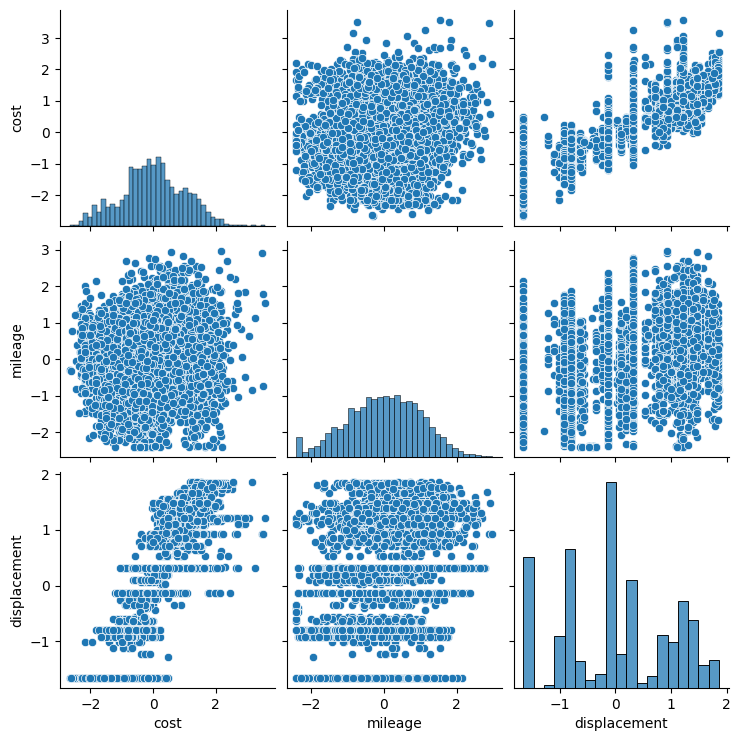

In [189]:
#数値データに関しては正規分布に従っていると言える
sns.pairplot(data_scaler)
plt.show()

In [190]:
category_featuers = ['color','brand','type']
ohe = OneHotEncoder(cols=category_featuers,handle_unknown='impute')
ohe.fit(data_scaler)
data_encoding = ohe.get_dummies(data_scaler)
data_encoding.fillna(0,inplace=True)

In [191]:
data_encoding

,cost,mileage,displacement,color_1,color_2,color_3,color_4,color_5,color_6,color_7,...,brand_6,brand_7,brand_8,brand_9,brand_10,type_1,type_2,type_3,type_4,type_5
0,-1.934417,-0.625926,-1.655476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.182723,-1.292303,0.314426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.566621,0.621130,-0.140117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.077167,-0.274886,0.098020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.054999,-0.086965,-0.140117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,0.796971,-0.574624,0.861787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6103,0.487124,0.599955,0.314426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6104,1.004332,1.409056,1.214031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6105,-0.196298,-0.056945,-0.140117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# UMAPによる可視化  
encodingをしたデータを用いてumapによる2次元データへの圧縮をする。  
dice係数を用いることで、カテゴリ変数も含めて次元削減が可能。  
可視化を行うことで、クラスタリングの様子を見やすくする。

In [157]:
numerical = data_encoding.iloc[:,:5]
categorical = data_encoding.iloc[:,5:]

#全特徴量のうちのカテゴリー変数の割合embedingに必要となる。
categorical_weight = len(categorical.columns)/len(data_encoding.columns)

fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

/Users/arimitsushuntarou/Downloads/yes/envs/python310/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [158]:
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False,False,False)

In [159]:
embedding[0][:,0]

array([3.550385 , 4.5930114, 5.274131 , ..., 6.671513 , 6.025486 ,
       5.3029113], dtype=float32)

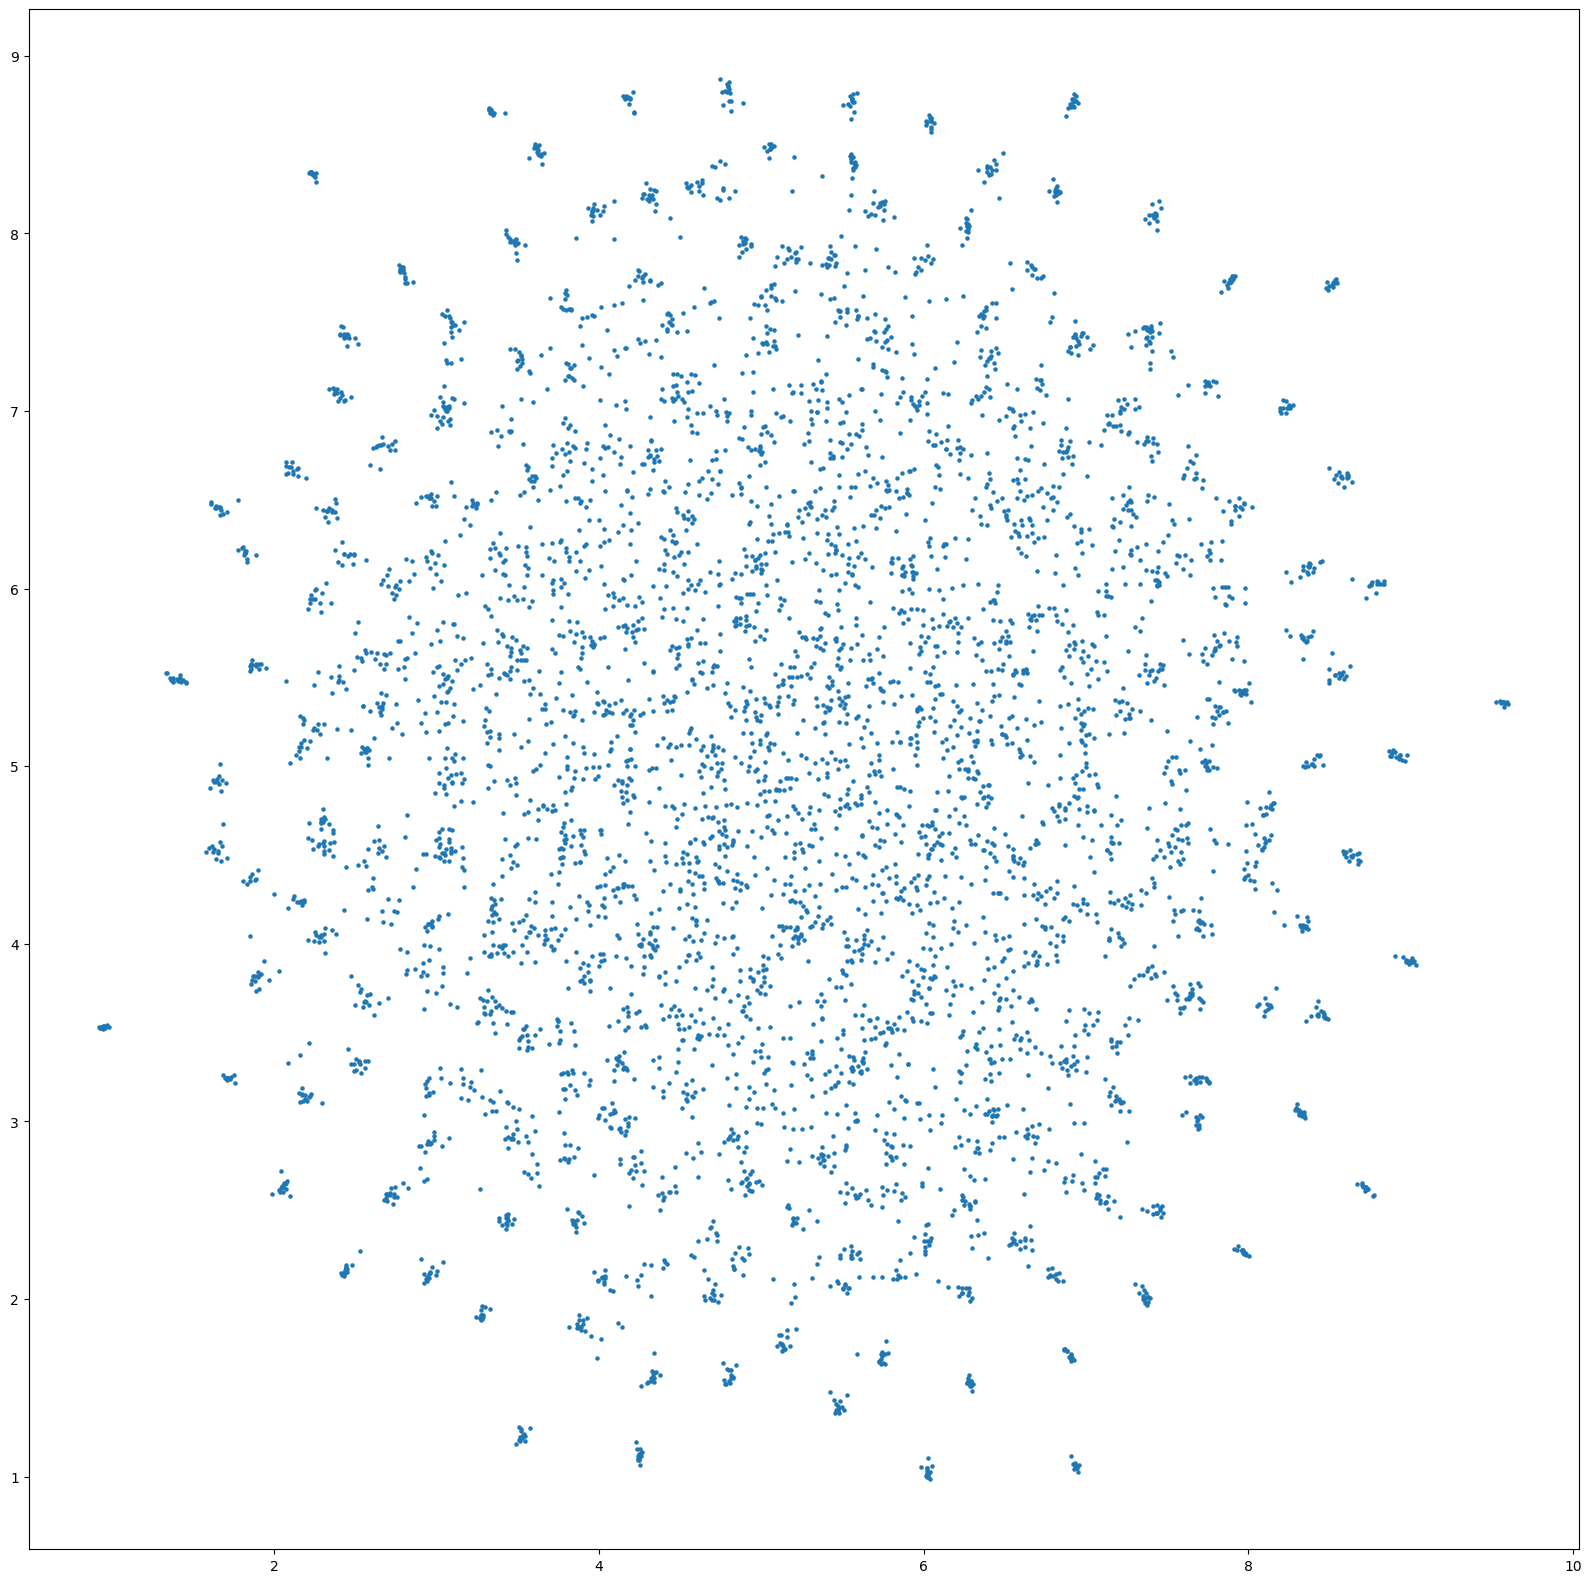

In [160]:
plt.figure(figsize=(20, 20))
plt.scatter(embedding[0][:,0],embedding[0][:,1], s=5)
plt.show()

# Kprototypes

# エルボー図を作成し最適なクラスタリング数を決める

In [161]:
data_scaler.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5600 entries, 0 to 6106
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mileage       5600 non-null   float64
 1   displacement  5600 non-null   float64
 2   color         5600 non-null   object 
 3   brand         5600 non-null   object 
 4   type          5600 non-null   object 
dtypes: float64(2), object(3)
memory usage: 262.5+ KB


In [162]:
data_scaler.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5600 entries, 0 to 6106
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mileage       5600 non-null   float64
 1   displacement  5600 non-null   float64
 2   color         5600 non-null   object 
 3   brand         5600 non-null   object 
 4   type          5600 non-null   object 
dtypes: float64(2), object(3)
memory usage: 262.5+ KB


100%|██████████| 24/24 [09:55<00:00, 24.82s/it]


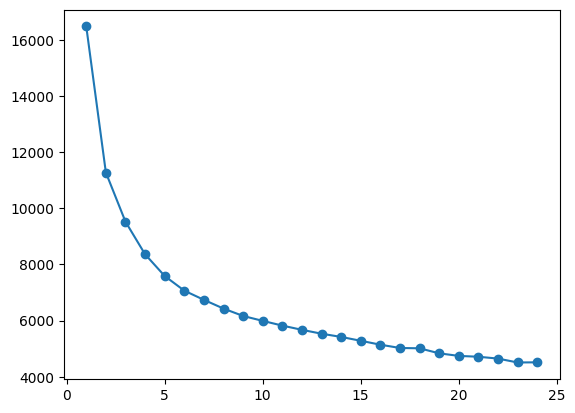

In [164]:
inertia =[]
for i in tqdm(range(1,25,1)):
    kpro = KPrototypes(n_jobs=-1,n_clusters=i,init='Huang',random_state=0,max_iter=300)
    kpro.fit_predict(data_scaler,categorical=[2,3,4])
    inertia.append(kpro.cost_)

plt.plot(range(1,25,1),inertia,marker='o')
plt.show()


エルボー図的には5クラスタが妥当か

In [166]:
kpro = KPrototypes(n_clusters=5,n_jobs=-1,init='Huang',random_state=0,max_iter=300)
cluster = kpro.fit_predict(data_scaler,categorical=[2,3,4])

# 可視化

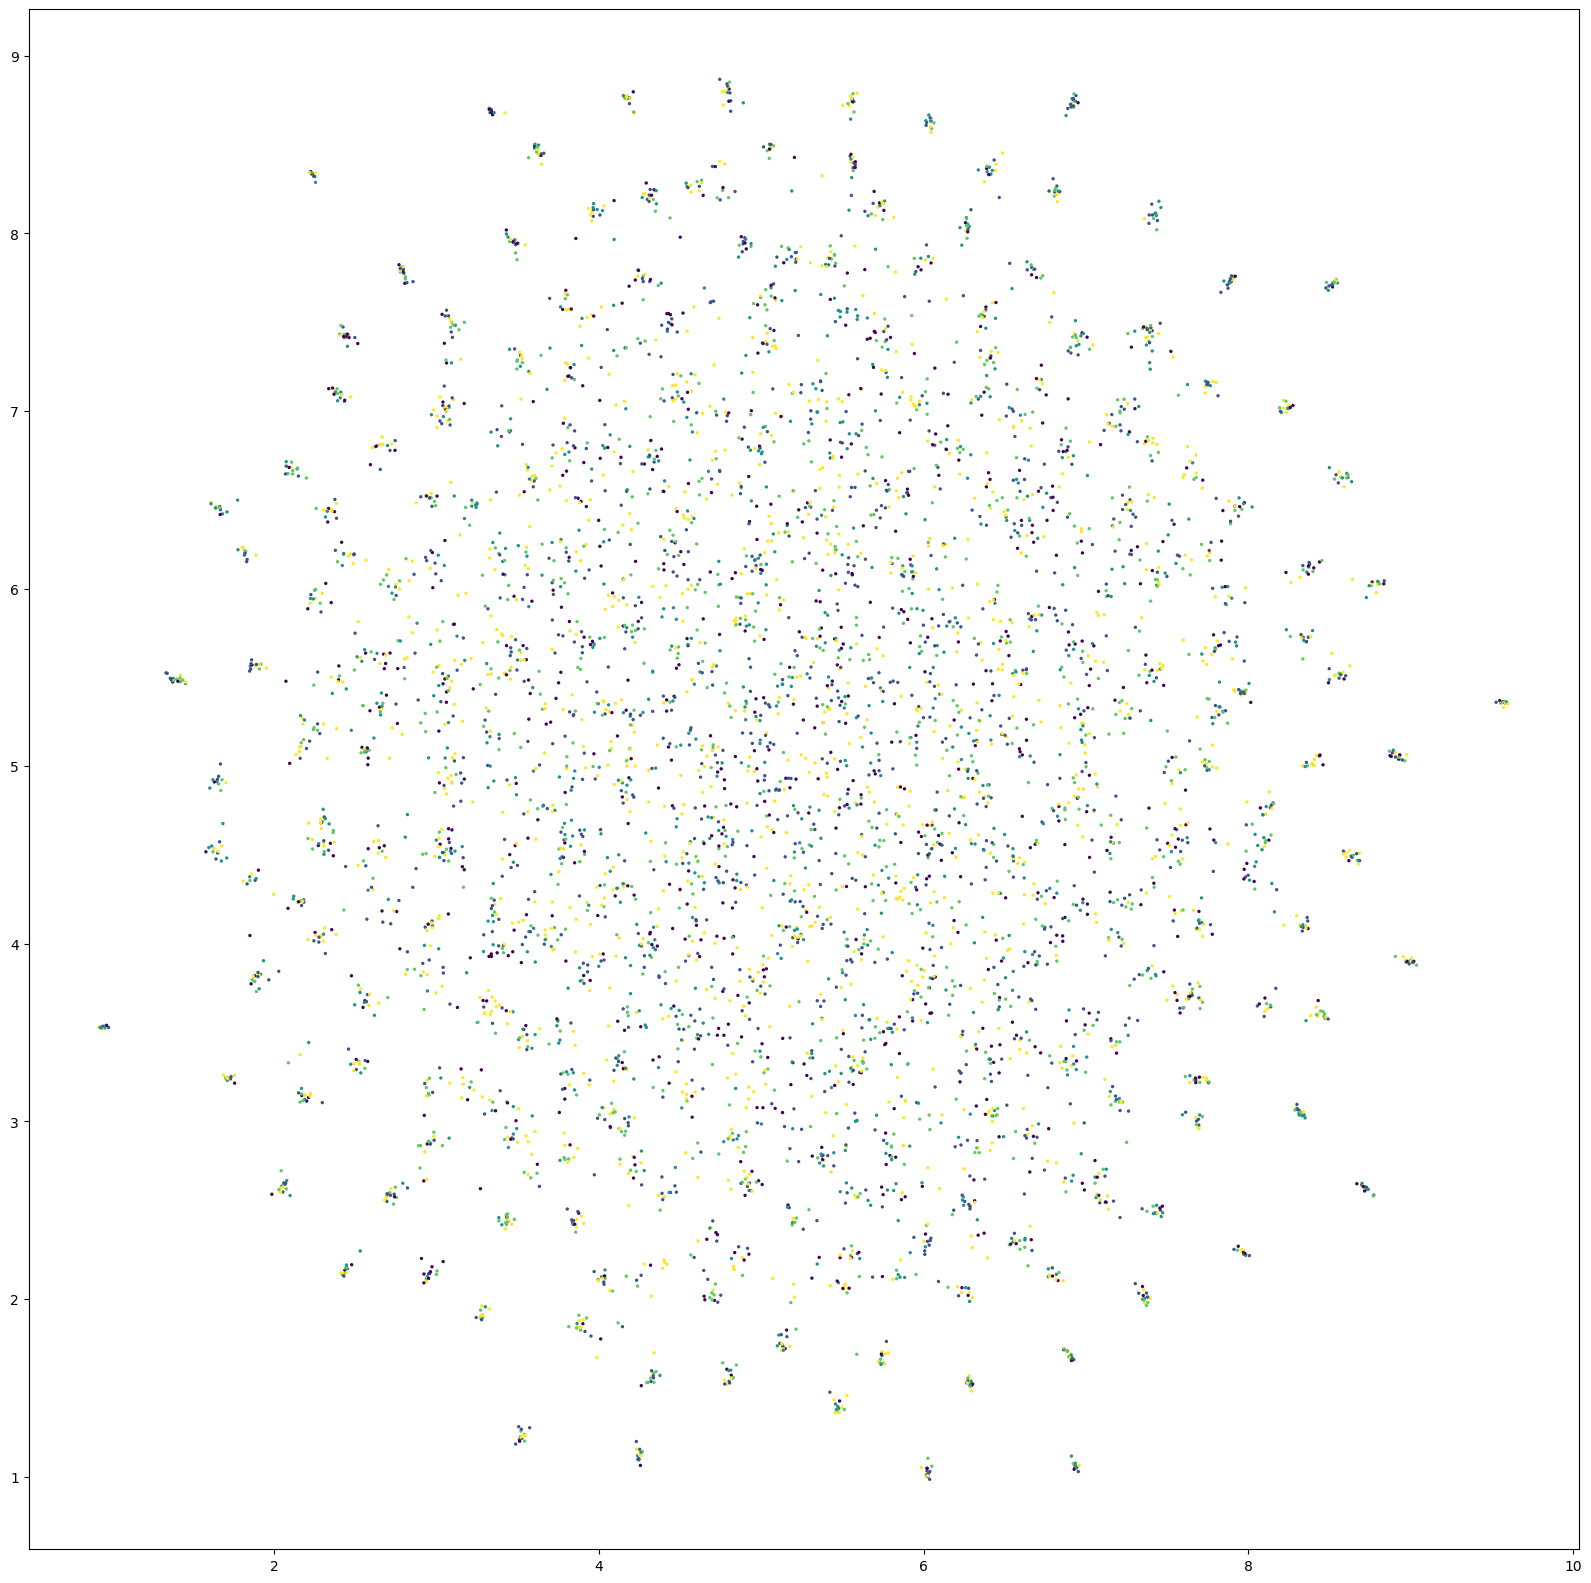

In [167]:
plt.figure(figsize=(20, 20))
plt.scatter(embedding[0][:,0],embedding[0][:,1],c=cluster, s=2)
plt.show()

In [168]:
data_scaler['cluster'] =cluster

In [169]:
all_data['cluster'] = cluster

In [170]:
all_data[all_data['cluster']==0]

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster
15,2100006021950,2548000,EBL-FD8,2017.0,黒,3137.0,3.0,77,Harley-Davidson,Dyna Low Rider S FXDLS1800,アメリカン/クルーザー,1800.0,0
24,2100006147780,728000,2BL-RH16J,2021.0,青,3898.0,7.0,46,YAMAHA,SR400,ネイキッド,400.0,0
25,2100005878821,1568000,2BL-DHJ1200,2023.0,黒,1979.0,7.0,34,Triumph,ｽﾋﾟｰﾄﾞﾂｲﾝ1200,ネイキッド,1200.0,0
30,2100006111866,1713640,2BL-ZR900C,2018.0,緑,1827.0,5.0,80,KAWASAKI,Z900RS,ネイキッド,950.0,0
36,2100005334266,2048000,2BL-XL3,2020.0,黒,4009.0,5.0,53,Harley-Davidson,XL1200NS,アメリカン/クルーザー,1200.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6071,2100005178402,2698000,2BL-ZR900C,2022.0,黄,1955.0,7.0,67,KAWASAKI,Z900RS,ネイキッド,950.0,0
6078,2100005617567,2100000,EBL-FLHL,2015.0,白,8206.0,1.0,5,Harley-Davidson,FLHTCUL,アメリカン/クルーザー,1690.0,0
6096,2100005905664,728000,2BL-RH16J,2019.0,青,2993.0,5.0,15,YAMAHA,SR400,ネイキッド,400.0,0
6098,2100006123517,1658000,2BL-ZR900C,2021.0,黒,415.0,7.0,66,KAWASAKI,Z900RS,ネイキッド,950.0,0


In [171]:
all_data[all_data['cluster']==1]

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster
1,2100004366077,1378000,EBL-NC42,2019.0,黒,776.0,5.00,2,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0,1
9,2100006257687,598000,JBK-DG17J,2017.0,茶,1417.0,3.00,78,YAMAHA,ｾﾛｰ250,オフロード/モタード,250.0,1
13,2100005658669,239000,2BH-AA09,2018.0,緑,66.0,1.00,66,HONDA,ｽｰﾊﾟｰｶﾌﾞ50,ネイキッド,50.0,1
14,2100005885829,328000,2BJ-JA44,2019.0,赤,1034.0,1.00,7,HONDA,ｽｰﾊﾟｰｶﾌﾞ110,ネイキッド,110.0,1
17,2100006180909,338000,2BK-SG52J,2018.0,黒,2972.0,5.00,16,YAMAHA,ﾏｼﾞｪｽﾃｨS,スクーター/ビッグスクーター,155.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6089,2100006134049,428000,2BK-KF47,2021.0,白,363.0,7.00,72,HONDA,PCX160,スクーター/ビッグスクーター,160.0,1
6090,2100005799959,418000,8BJ-JA58,2022.0,赤,1687.0,3.00,1,HONDA,ｽｰﾊﾟｰｶﾌﾞC125,ネイキッド,125.0,1
6092,2100006019469,398000,JBK-RG10J,2015.0,青,2555.0,1.00,2,YAMAHA,YZFR25,スポーツ/ツアラー,250.0,1
6093,2100005889988,458000,2BJ-JA55,2020.0,茶,1061.0,1.00,2,HONDA,CT125ﾊﾝﾀｰｶﾌﾞ,ネイキッド,125.0,1


In [172]:
all_data[all_data['cluster']==2]

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster
6,2100005940696,598000,EBL-RM07J,2014.0,銀,16450.0,1.000000,34,YAMAHA,MT07,ネイキッド,700.0,2
12,2100005724951,515000,ER650A,2013.0,緑,17306.0,1.000000,72,KAWASAKI,ER6n,ネイキッド,650.0,2
18,2100005890151,498000,EBL-NC47,2013.0,赤,22007.0,1.000000,5,HONDA,400X,オフロード/モタード,400.0,2
20,2100004863958,838000,BC-EJ650A,2005.0,青,26929.0,0.250000,35,KAWASAKI,W650,ネイキッド,650.0,2
22,2100004464841,828000,SC50,2002.0,黄,18764.0,0.083333,35,HONDA,CBR954RR,スポーツ/ツアラー,954.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6077,2100006247428,548000,2BL-VP55B,2019.0,銀,17722.0,3.000000,49,SUZUKI,SV650X,ネイキッド,650.0,2
6083,2100005444323,820000,ZX4R,2015.0,黒,30410.0,0.250000,8,KAWASAKI,Ninja ZX6Rﾊﾞｯｸｽﾃｯﾌﾟ,スポーツ/ツアラー,600.0,2
6084,2100006151442,1348000,EBL-SC59,2015.0,限定,15763.0,1.000000,46,HONDA,CBR1000RR,スポーツ/ツアラー,1000.0,2
6088,2100005719339,2380000,EBL-FLC,2018.0,黒,26770.0,1.000000,58,Harley-Davidson,,アメリカン/クルーザー,1750.0,2


In [173]:
all_data[all_data['cluster']==3]

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster
0,2100006155617,118000,JBH-AF67,2012.0,黒,2742.0,0.250000,51,HONDA,ﾄｩﾃﾞｲ,スクーター/ビッグスクーター,50.0,3
10,2100005566087,628000,A-AC12,1993.0,赤,4330.0,0.083333,6,HONDA,NS1,スポーツ/ツアラー,50.0,3
11,2100005943543,204000,BB-SA10J,2018.0,黒,1468.0,1.000000,62,YAMAHA,VINO,スクーター/ビッグスクーター,50.0,3
29,2100006195934,200000,JBH-AA01,2008.0,黒,4861.0,0.250000,5,HONDA,ﾘﾄﾙｶﾌﾞ,ネイキッド,50.0,3
34,2100005575324,328000,2BK-SG50J,2017.0,赤,6265.0,3.000000,59,YAMAHA,NMAX155,スクーター/ビッグスクーター,155.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6070,2100005939812,143000,2BH-AY02,2019.0,青,15583.0,0.250000,54,YAMAHA,Vino,スクーター/ビッグスクーター,50.0,3
6073,2100005661256,690000,2BK-MF15,2021.0,白,3957.0,7.000000,44,HONDA,ﾌｫﾙﾂｧ,スクーター/ビッグスクーター,250.0,3
6074,2100006159042,158000,JBH-AF79,2019.0,白,1933.0,1.000000,61,HONDA,ﾀｸﾄﾍﾞｰｼｯｸ,スクーター/ビッグスクーター,50.0,3
6075,2100005804912,198000,EBJ-CF4MA,2017.0,黒,6752.0,0.250000,35,SUZUKI,ｱﾄﾞﾚｽV125S,スクーター/ビッグスクーター,125.0,3


In [174]:
all_data[all_data['cluster']==4]

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster
2,2100005457217,348000,JBK-ER250C,2013.0,白,11979.0,1.00,58,KAWASAKI,Z250,ネイキッド,250.0,4
3,2100005410007,578000,EBL-RH07J,2020.0,黒,4500.0,5.00,37,YAMAHA,MT03,ネイキッド,320.0,4
4,2100005346689,568000,JUE4,2021.0,黒,5688.0,5.00,81,Husqvarna,SVARTPILEN 250,ネイキッド,250.0,4
7,2100005410144,458000,JBK-RG10J,2019.0,青,27167.0,1.00,37,YAMAHA,YZFR25,スポーツ/ツアラー,250.0,4
16,2100005754453,298000,2BJ-DL33B,2021.0,黒,16234.0,0.25,9,SUZUKI,GSXR125 ABS,スポーツ/ツアラー,125.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100,2100006166712,458000,BA-BJ250F,2004.0,緑,4639.0,0.25,11,KAWASAKI,250TR,ネイキッド,250.0,4
6101,2100006024395,348000,JBK-LX250S,2008.0,黒,25110.0,0.25,2,KAWASAKI,KLX250,オフロード/モタード,250.0,4
6103,2100006214697,798000,BC-SK44A,2008.0,黒,11745.0,0.25,3,SUZUKI,DRZ400SM,オフロード/モタード,400.0,4
6105,2100006271508,466000,JBK-RG10J,2019.0,赤,5895.0,5.00,54,YAMAHA,YZFR25,スポーツ/ツアラー,250.0,4


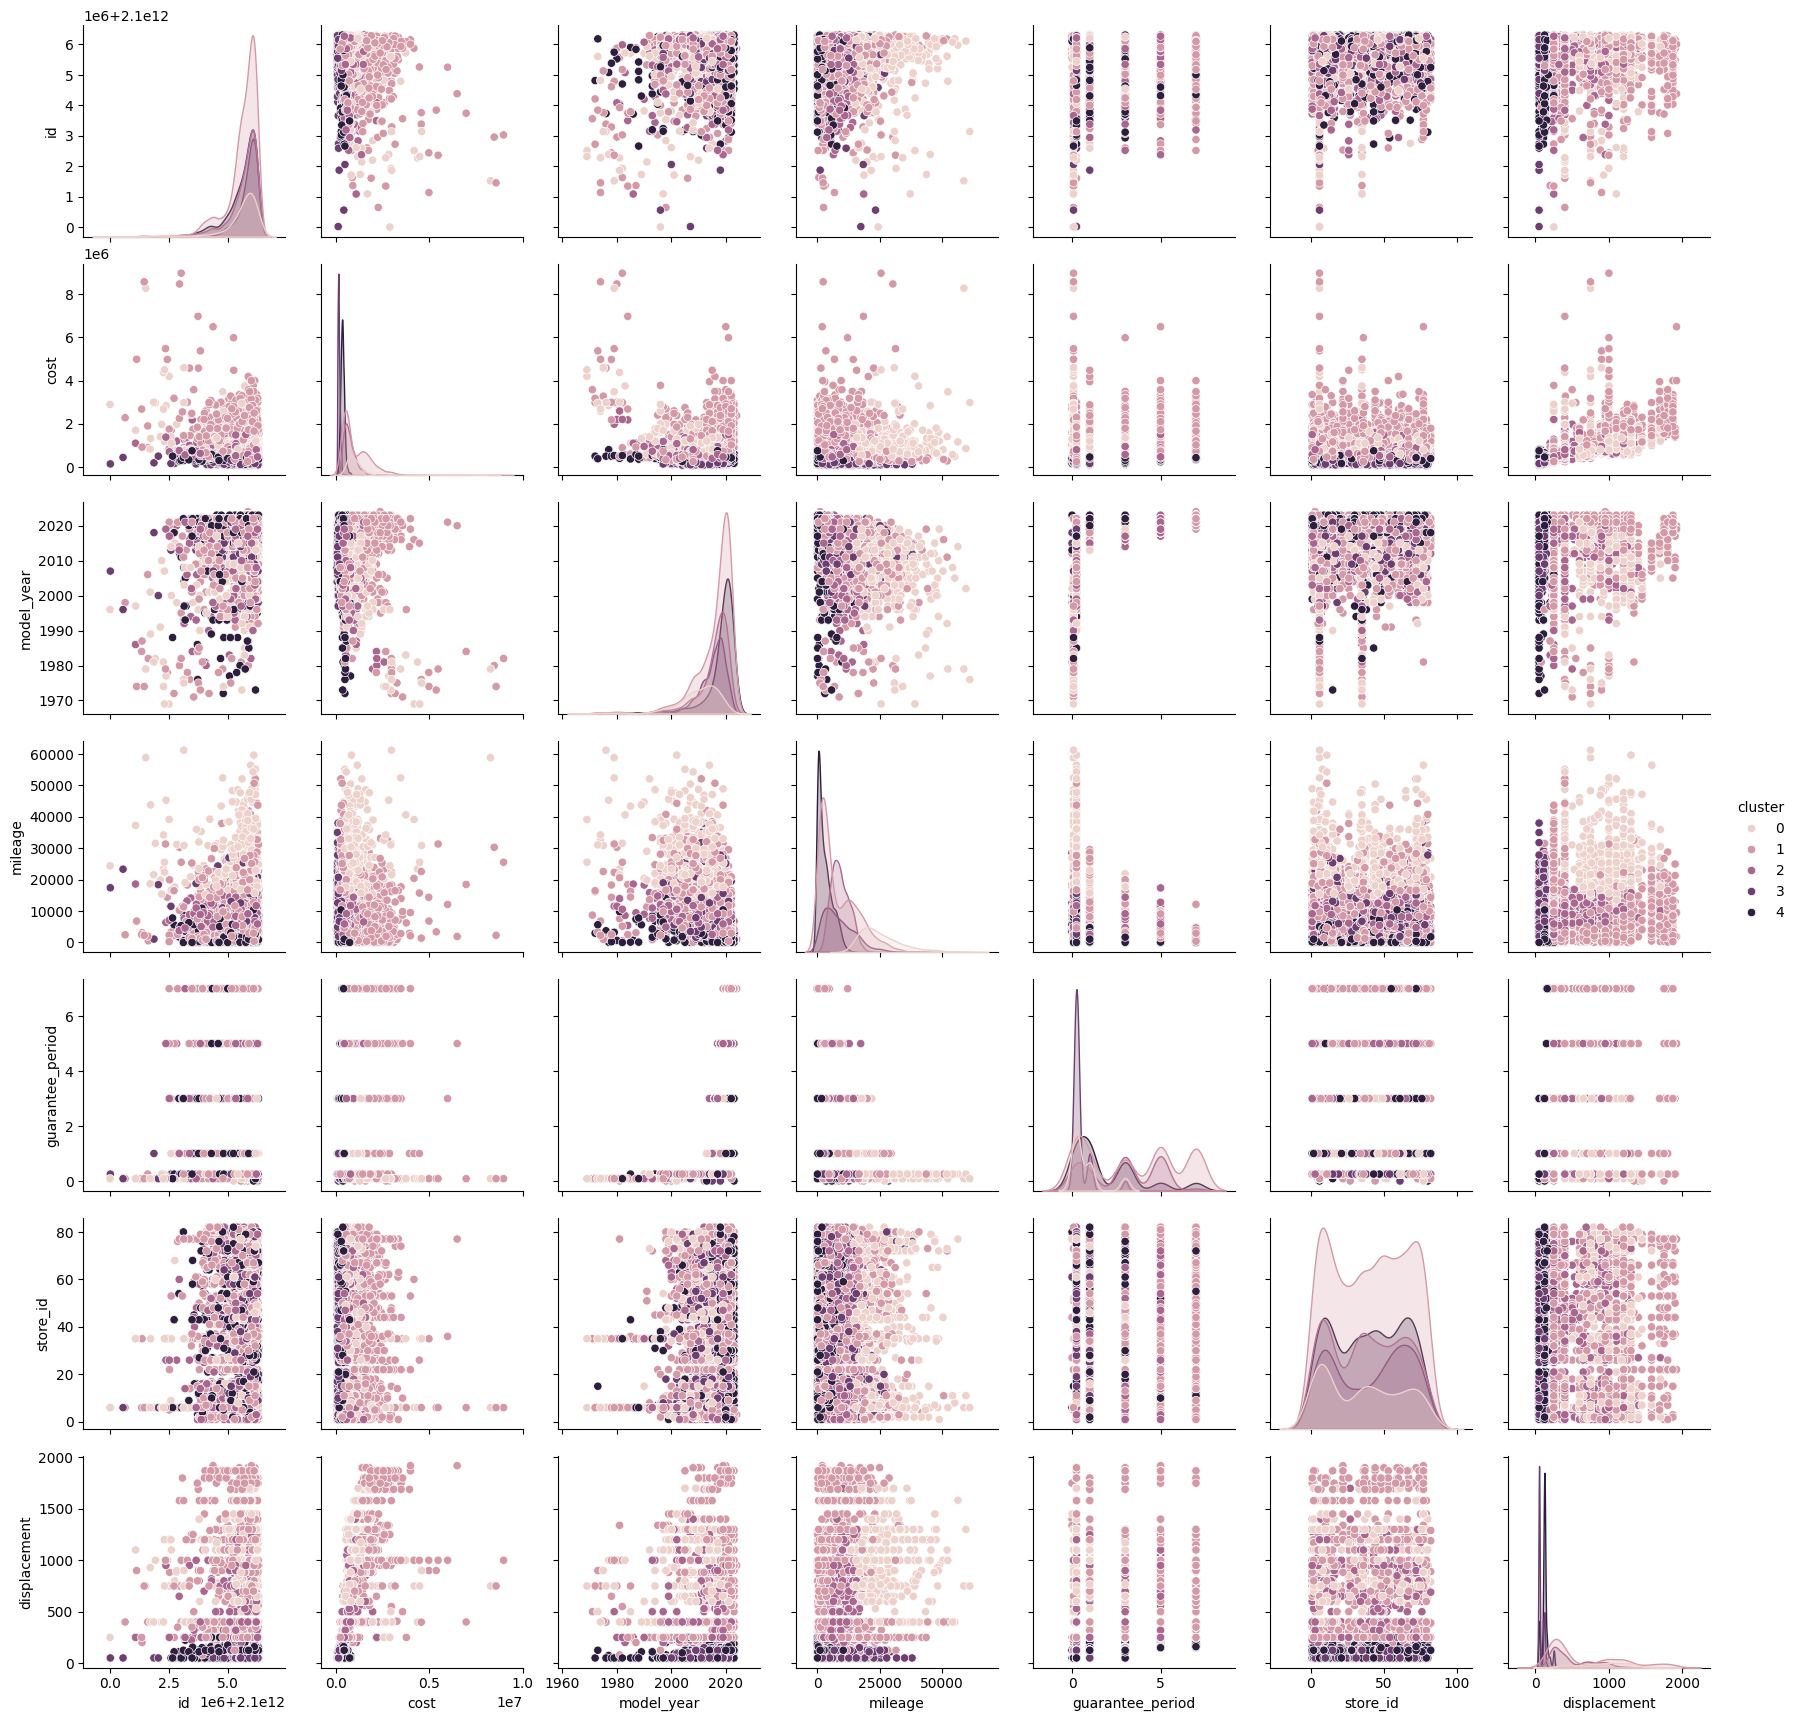

In [ ]:
sns.pairplot(data=all_data,hue='cluster')

# UMAPで得たデータをもとにKmeansを行う  
そもそもUMAPでカテゴリ変数も含めて次元削減をしているのであれば、これをもとにKmeansをしてしまえば良いと考えた。  
次元の数も少ないため、次元の呪いも考慮しなくて良い。

In [195]:
umap_featuer = embedding[0]

  0%|          | 0/24 [00:00<?, ?it/s]/Users/arimitsushuntarou/Downloads/yes/envs/python310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arimitsushuntarou/Downloads/yes/envs/python310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arimitsushuntarou/Downloads/yes/envs/python310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/arimitsush

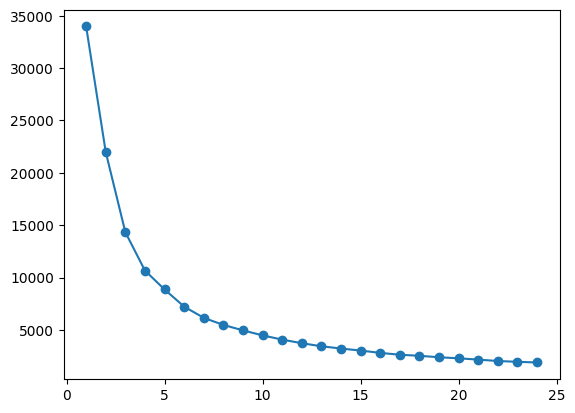

In [206]:
inertia =[]
for i in tqdm(range(1,25,1)):
    km = KMeans(n_clusters=i,random_state=0,max_iter=300)
    km.fit(umap_featuer)
    inertia.append(km.inertia_)

plt.plot(range(1,25,1),inertia,marker='o')
plt.show()


In [212]:
km = KMeans(n_clusters=6,random_state=0,max_iter=300)
km.fit(umap_featuer)
cluster_km = km.predict(umap_featuer)

/Users/arimitsushuntarou/Downloads/yes/envs/python310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [213]:
cluster_km

array([4, 5, 5, ..., 3, 3, 2], dtype=int32)

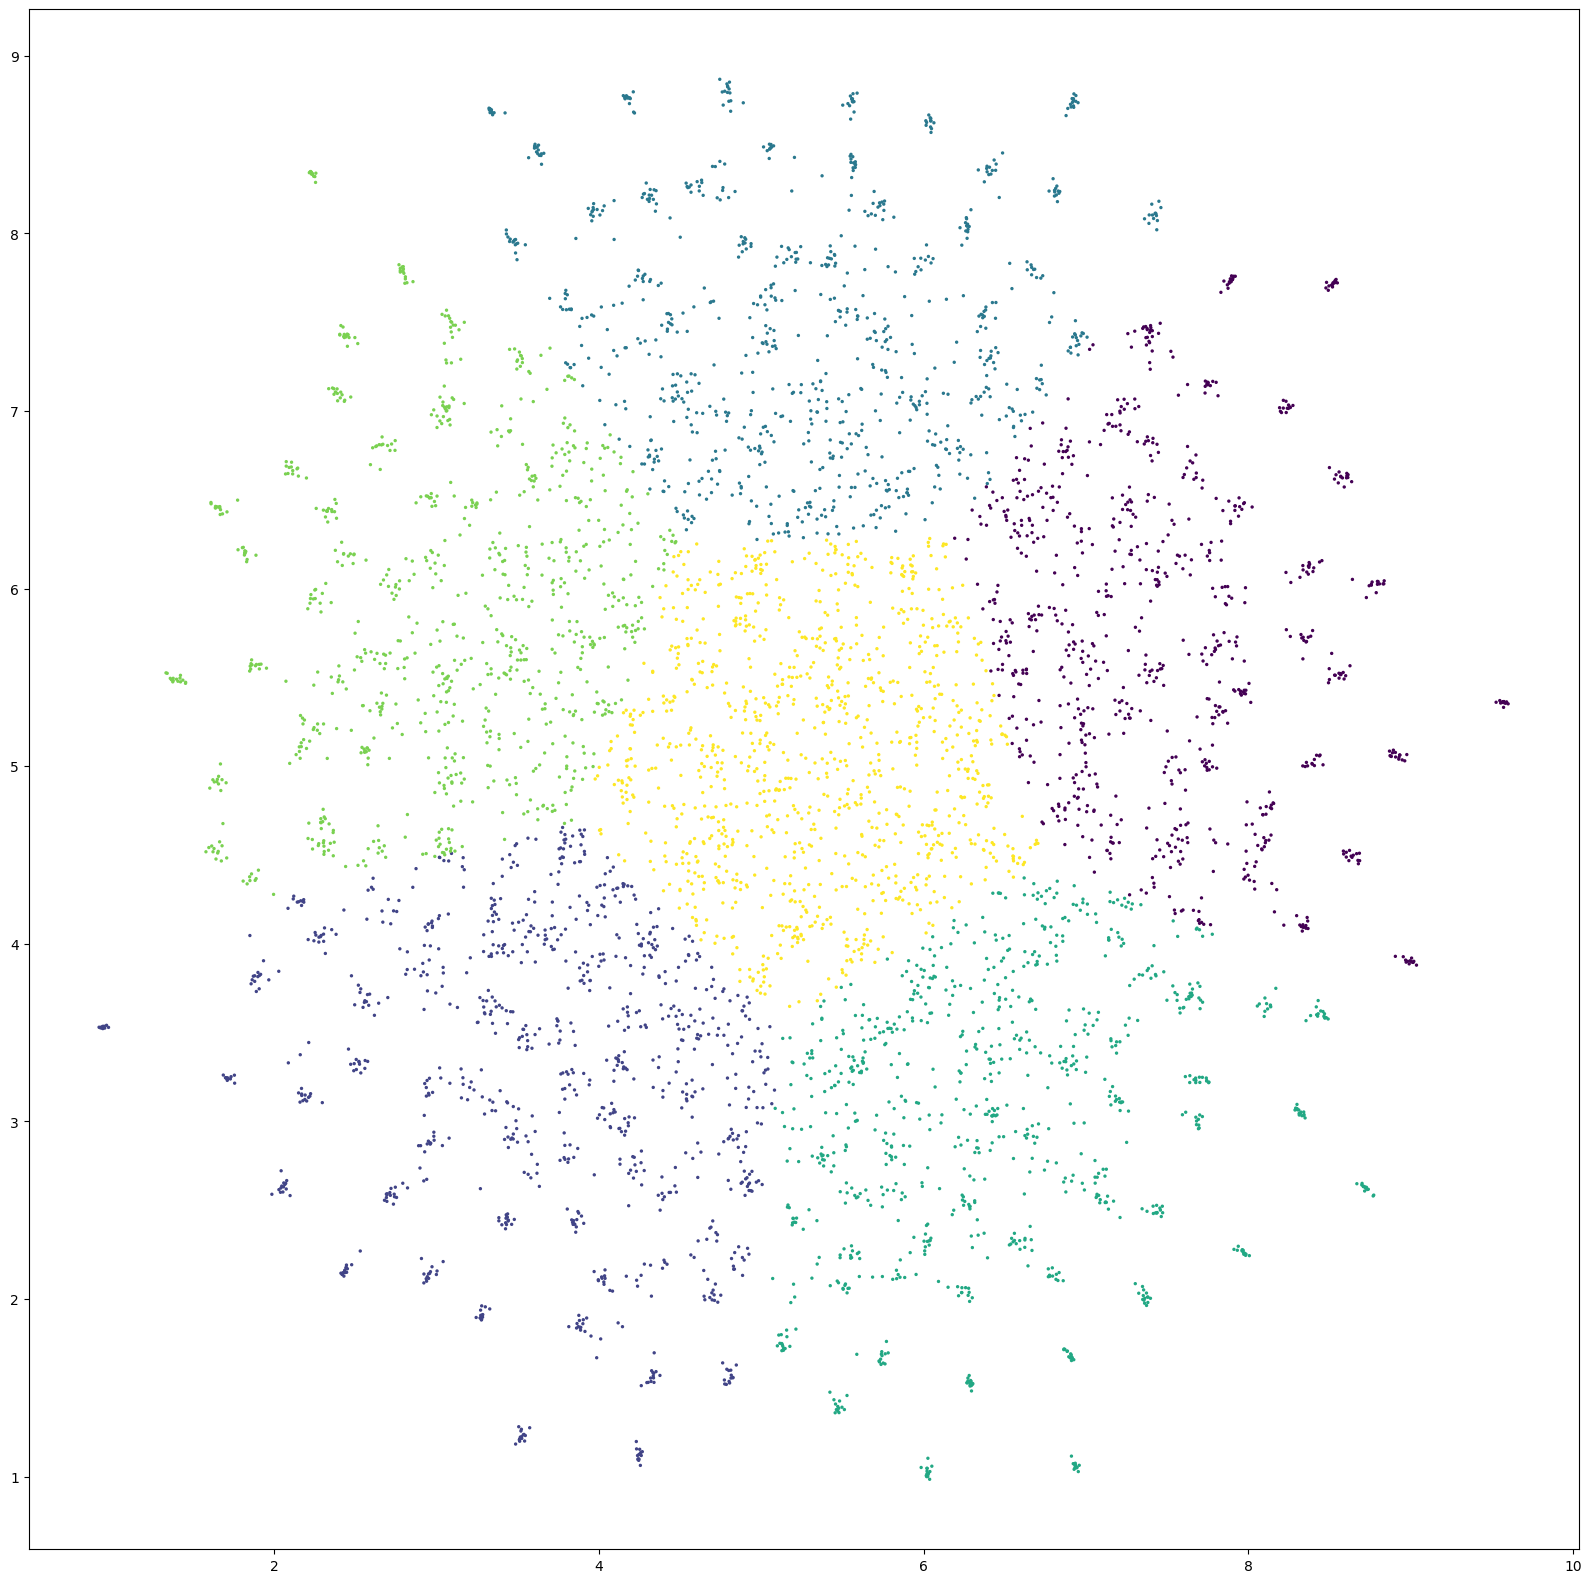

In [214]:
plt.figure(figsize=(20, 20))
plt.scatter(embedding[0][:,0],embedding[0][:,1],c=cluster_km, s=2)
plt.show()

In [215]:
all_data['cluster_km'] = cluster_km

In [216]:
all_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster_km
0,2100006155617,118000,JBH-AF67,2012.0,黒,2742.0,0.25,51,HONDA,ﾄｩﾃﾞｲ,スクーター/ビッグスクーター,50.0,4
1,2100004366077,1378000,EBL-NC42,2019.0,黒,776.0,5.00,2,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0,5
2,2100005457217,348000,JBK-ER250C,2013.0,白,11979.0,1.00,58,KAWASAKI,Z250,ネイキッド,250.0,5
3,2100005410007,578000,EBL-RH07J,2020.0,黒,4500.0,5.00,37,YAMAHA,MT03,ネイキッド,320.0,2
4,2100005346689,568000,JUE4,2021.0,黒,5688.0,5.00,81,Husqvarna,SVARTPILEN 250,ネイキッド,250.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,2100006097726,1018000,8BL-RM39J,2022.0,青,2964.0,7.00,67,YAMAHA,YZFR7,スポーツ/ツアラー,700.0,2
6103,2100006214697,798000,BC-SK44A,2008.0,黒,11745.0,0.25,3,SUZUKI,DRZ400SM,オフロード/モタード,400.0,1
6104,2100006202625,1198000,EBL-SC59,2013.0,オレンジ,23013.0,1.00,74,HONDA,CBR1000RR,スポーツ/ツアラー,1000.0,3
6105,2100006271508,466000,JBK-RG10J,2019.0,赤,5895.0,5.00,54,YAMAHA,YZFR25,スポーツ/ツアラー,250.0,3


In [219]:
all_data[all_data['cluster_km']==2]

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement,cluster_km
3,2100005410007,578000,EBL-RH07J,2020.0,黒,4500.0,5.00,37,YAMAHA,MT03,ネイキッド,320.0,2
34,2100005575324,328000,2BK-SG50J,2017.0,赤,6265.0,3.00,59,YAMAHA,NMAX155,スクーター/ビッグスクーター,155.0,2
36,2100005334266,2048000,2BL-XL3,2020.0,黒,4009.0,5.00,53,Harley-Davidson,XL1200NS,アメリカン/クルーザー,1200.0,2
43,2100006153385,119800,JBH-AF79,2021.0,黒,6298.0,0.25,63,HONDA,ﾀｸﾄﾍﾞｰｼｯｸ,スクーター/ビッグスクーター,50.0,2
46,2100006288551,1388000,2BL-NC42,2019.0,青,3545.0,5.00,72,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6077,2100006247428,548000,2BL-VP55B,2019.0,銀,17722.0,3.00,49,SUZUKI,SV650X,ネイキッド,650.0,2
6078,2100005617567,2100000,EBL-FLHL,2015.0,白,8206.0,1.00,5,Harley-Davidson,FLHTCUL,アメリカン/クルーザー,1690.0,2
6097,2100003491350,748000,BA-AB27,2017.0,白,7.0,0.25,43,HONDA,ﾓﾝｷｰ,ネイキッド,50.0,2
6102,2100006097726,1018000,8BL-RM39J,2022.0,青,2964.0,7.00,67,YAMAHA,YZFR7,スポーツ/ツアラー,700.0,2
